# 图像拼接

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
pic1=cv2.imread('timg1.png')
pic2=cv2.imread('timg4.png')
pic1.shape,pic2.shape

((692, 695, 3), (951, 945, 3))

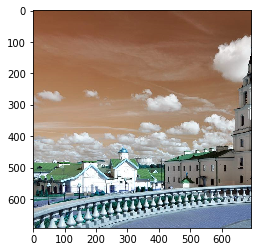

In [3]:
plt.imshow(pic1)
plt.show()

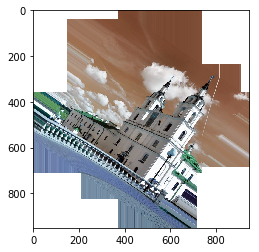

In [4]:
plt.imshow(pic2)
plt.show()

In [5]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(pic1, None)
kp2, des2 = sift.detectAndCompute(pic2, None)

In [6]:
des1=np.array(des1)
des2=np.array(des2)
kp1=np.array(kp1)
kp2=np.array(kp2)

In [7]:
from sklearn.neighbors import NearestNeighbors
# 两个列表用于记录匹配点在关键点列表中的位置
des1_place=[]
des2_place=[]
model=NearestNeighbors(n_neighbors=2).fit(des2)
for i,j in enumerate(des1):
    # 查找2个最近邻，如果距离之比小于0.8，则认为是匹配点，记录匹配点位置
    distance,place=model.kneighbors(j.reshape(1,128),2, return_distance=True)
    if distance[0][0]<0.8*distance[0][1]:
        des1_place.append(i)
        des2_place.append(place[0][0])

In [8]:
kp1_new=kp1[des1_place]
des1_new=des1[des1_place]
kp2_new=kp2[des2_place]
des2_new=des2[des2_place]
bf = cv2.BFMatcher(normType=cv2.NORM_L1, crossCheck=True)
matches = bf.match(des1_new,des2_new)
len(matches)

817

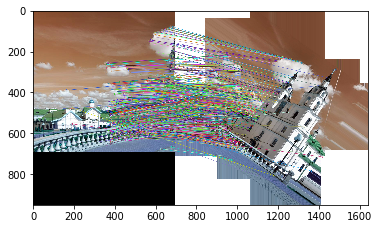

In [9]:
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1=pic1,keypoints1=kp1_new,img2=pic2,keypoints2=kp2_new, matches1to2=matches, outImg=pic2, flags=2)
plt.imshow(img3)
plt.show()

In [10]:
# 取出匹配点的坐标，最后一维的形状为2，即x和y的值
src_pts = np.float32([kp1[i].pt for i in des1_place]).reshape(-1,1,2)
dst_pts = np.float32([kp2[i].pt for i in des2_place]).reshape(-1,1,2)

In [11]:
# cv2.findHomography返回值中H为变换矩阵，mask是掩码，即局内点
H, mask = cv2.findHomography(dst_pts,src_pts, cv2.RANSAC, 5.0)
H

array([[ 8.19478876e-01,  5.73614510e-01,  2.88960570e+01],
       [-5.73477236e-01,  8.19351681e-01,  2.27521223e+02],
       [ 3.94577851e-07,  1.78552679e-08,  1.00000000e+00]])

In [12]:
# 计算单应性矩阵
def cal_homography(src_kp,dst_kp):
    """"src_kp and dst_kp have four couple of keypoints
    A=[[x1,y1,1,0,0,0,-x1'x1,-x1'y1,-x1'],
    [0,0,0,x1,y1,1,-y1'x1,-y1'y1,-y1'],
    [x2,y2,1,0,0,0,-x2'x2,-x2'y2,-x2'],
    [0,0,0,x2,y2,1,-y2'x2,-y2'y2,-y2'],
    [x3,y3,1,0,0,0,-x3'x3,-x3'y3,-x3'],
    [0,0,0,x3,y3,1,-y3'x3,-y3'y3,-y3'],
    [x4,y4,1,0,0,0,-x4'x4,-x4'y4,-x4'],
    [0,0,0,x4,y4,1,-y4'x4,-y4'y4,-y4'],
    [0,0,0,0,0,0,0,  0,       0,   1]]
    b=[0,0,0,0,0,0,0,0,0,1]
    solve Ax=b
    """
    A=np.zeros((8,9))
    place1=[0,2,4,6]
    place2=[1,3,5,7]
    src_data=np.hstack((src_kp, np.ones((4, 1))))
    A[place1,0:3]=src_data
    A[place2,3:6]=src_data
    A[place1,6:9]=-dst_kp[:,0].reshape(4,1)*src_data
    A[place2,6:9]=-dst_kp[:,1].reshape(4,1)*src_data
    # line_nine为零的地方给予一个很小的数，使矩阵的值非零
    line_nine=np.array([1e-10,1e-10,1e-10,1e-10,1e-10,1e-10,1e-10,1e-10,1])
    b= np.array([0,0,0,0,0,0,0,0,1])
    A=np.vstack((A,line_nine))
    x=np.linalg.solve(A,b)
    x=x.reshape(3,3)
    return x

In [13]:
# 自定义的ransac函数计算单应性矩阵
def ransac(src_kp,dst_kp,tolerent_sigma,iterations=100,thresh_size = 0.5,flag=0):
    """RANSAC in homography
    @param src_kp,dst_kp=H.src_kp
    @param dst_kp
    @param tolerent_sigma,允许误差值
    @param iterations,迭代次数
    @param thresh_size,局内点超过一定百分比之后停止迭代
    @param flag,flag=0，每次都是取四个随机值，flag=1，每次都是从inliers中取,

    """

    # 初始化局内点数量和局内点列表
    pretotal = 0
    inliers=[]
    SIZE=len(src_kp)
    for i in range(iterations):
        # 4对点计算单应性矩阵
        if flag==0:
            # 每次都从所有样本点中随机取值
            sample_index = random.sample(range(SIZE), 4)
            inliers = np.hstack((src_kp[sample_index], dst_kp[sample_index]))
        else:
            # 每次更新inliers，每次从inliers中取4对点
            if len(inliers)<=4 or i==0 :
                # 如果局内点数量小于等于4个，从所有样本中重新随机选择
                sample_index = random.sample(range(SIZE), 4)
                inliers = np.hstack((src_kp[sample_index], dst_kp[sample_index]))
            else:
                sample_index = random.sample(range(len(inliers)), 4)
                inliers = inliers[sample_index]

        src_current = inliers[:,0:2]
        dst_current = inliers[:,2:4]
        # H,_ =cv2.findHomography(src_current,dst_current)
        H=cal_homography(src_current,dst_current)

        # 计算目标点变换后的坐标，并计算欧式距离
        src_data = np.hstack((src_kp, np.ones((SIZE, 1))))
        transform_kp=(np.dot(H,src_data.T)).T
        dis=np.sqrt((dst_kp[:,0]-transform_kp[:,0])**2+(dst_kp[:,1]-transform_kp[:,1])**2)

        # 找出误差小于容忍误差的值的位置，并加入inliers
        inlier_index=dis<tolerent_sigma
        inliers=np.hstack((src_kp[inlier_index],dst_kp[inlier_index]))
        total_inliers = inliers.shape[0]

        if total_inliers > pretotal:
            pretotal = total_inliers
            best_H = H

        if total_inliers >= SIZE * thresh_size:
            break
    return best_H,inliers

In [14]:
src_kp=src_pts.reshape(src_pts.shape[0],2)
dst_kp=dst_pts.reshape(dst_pts.shape[0],2)
H,_=ransac(dst_kp,src_kp,5.0)
H

array([[ 8.13417299e-01,  5.66535326e-01,  3.14141243e+01],
       [-5.73174889e-01,  8.13709598e-01,  2.27943225e+02],
       [-4.51670108e-06, -7.22708787e-06,  9.99999974e-01]])

In [15]:
# 获取原图像的高和宽
h1,w1,p1 = pic1.shape
h2,w2,p2 = pic2.shape

# 新图像高度取两者大值
h = np.maximum(h1,h2)
# 计算移动的距离，取出待拼接图像与源图像中较大的x坐标，即重合的区域
movedis = int(np.maximum(dst_pts[0][0][0],src_pts[0][0][0]))
# 宽度需要扣除重合区域
w=w1+w2-movedis

# cv2.warpPerspective，参数为需要变换的图像，单应性矩阵，变换后的尺寸wxh
rightimg = cv2.warpPerspective(pic2,H,(w,h))
print(rightimg.shape)

(951, 960, 3)


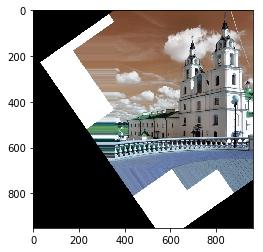

In [16]:
# # 输出变换后的图像
plt.imshow(rightimg)
plt.show()

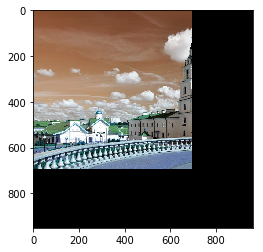

In [17]:
# # 拼接图像
# 坐标[x,y]x([[1, 0, 0], [0, 1, 0]])=[x,y,0]，即没有任何变化
M1 = np.float32([[1, 0, 0], [0, 1, 0]])
# 采用变换的方法，可以扩充图像但不改变源图像的像素
dst1 = cv2.warpAffine(pic1,M1,(w, h))
plt.imshow(dst1)
plt.show()

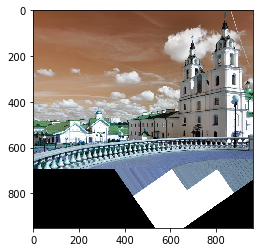

In [18]:
# 自定义拼接函数，将leftimg中的所有像素保留，其余像素采用rightimg中的像素
def merge(leftimg,rightimg,h,w):
    dst_target=np.zeros((h,w,3))
    for i in range(h):
        for j in range(w):
            if i<h1 and j<w1:
                dst_target[i,j]=leftimg[i,j]
            else:
                dst_target[i,j]=rightimg[i,j]
    dst_target=dst_target.astype('uint8')
    return dst_target

leftimg=pic1
dst_target=merge(leftimg,rightimg,h,w)
plt.imshow(dst_target)
plt.show()